# Address Standardization Using Model Extension: A Modern Approach

## Table of Contents

[Introduction](#Introduction)\
[Imports](#Imports)\
[Prompt Engineering](#Prompt-Engineering)\
[Esri Model Definition(EMD) file](#Esri-Model-Definition(EMD)-file)\
[Anatomy of the Extension Function](#anatomy-of-the-extension-function)
* [Define the ```__init__``` function](#define-the-__init__-function)
* [Define the ```getParameterInfo``` function](#define-the-getconfiguration-function)
* [Define the ```initialize``` function](#define-the-initialize-function)
* [Define the ```getConfiguration``` function](#define-the-getparameterinfo-function)
* [Define the ```predict``` function](#define-the-predict-function)

[Complete NLP Function](#Complete-NLP-Function)\
[Create Custom ESRI Deep Learning Package (.dlpk) file](#Create-Custom-ESRI-Deep-Learning-Package-(.dlpk)-file)\
[Using the custom ESRI Deep Learning Package (.dlpk) file in arcgis.learn API](#Using-the-custom-ESRI-Deep-Learning-Package-(.dlpk)-file-in-arcgis.learn-API)\
[Tool Interface](#tool-interface)\
[Sample Input Table](#Sample-Input-Table)\
[Sample Output Table](#Sample-Output-Table)\
[Conclusion](#conclusion)

## Introduction

The **GeoAI toolbox** features a comprehensive **Text Analysis toolset** designed for diverse text processing tasks, including _text classification, entity extraction, and text transformation_. Leveraging advanced natural language processing (NLP) models built on powerful backbones like BERT, RoBERTa, T5, and large language models (LLMs) such as Mistral, these tools deliver high-performance text analysis.

But what if you encounter a **Text model**, like a **BERT** or **T5** backbone-based language model, or a **large language model (LLM)** such as **LLaMA**, **Claude**, or **Mistral**, that isn’t included in the current learning module? Perhaps you want to utilize it from a library or an open-source code repository. Or maybe you’ve fine-tuned your own **text model** for specific tasks, such as standardizing addresses, conducting sentiment analysis, or extracting custom entities or relationships not currently supported by the Text Analysis toolset. How can you implement this within **ArcGIS Pro**?

To address these needs, ArcGIS allows for the integration of external third-party language models, including both open-source LLMs and commercial LLMs accessed via web APIs. Please note that if you use a web-hosted LLM, the data processed will be sent to the LLM provider. Python developers can create custom NLP functions to interface with these external models, packaging their models as Esri deep learning packages (ESRI Deep Learning Package (.dlpk) files) for use with the following tools:

1. [Classify Text Using Deep Learning (GeoAI)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/classify-text-using-deep-learning.htm)
2. [Extract Entities Using Deep Learning (GeoAI)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/extract-entities-using-deep-learning.htm)
3. [Transform Text Using Deep Learning (GeoAI)](https://pro.arcgis.com/en/pro-app/latest/tool-reference/geoai/transform-text-using-deep-learning.htm)

The ESRI Deep Learning Package (.dlpk) file of the custom NLP function is also supported through the `arcgis.learn` Python API, which accommodates third-party custom models via various classes, including `TextClassifier`, `EntityRecognizer`, and `SequenceToSequence`.

This document showcases a use case where a hosted commercial LLM was employed for an address standardization task. It provides a step-by-step guide detailing the components of the **NLP Function** and outlines the process for creating a ESRI Deep Learning Package (.dlpk) file using this function. Additionally, we will demonstrate how to accomplish the same task using our **Python API** interface.

 **Address Standardization** is the process of formatting addresses to ensure consistency and accuracy. It involves correcting spelling errors, unifying abbreviations, and conforming to postal regulations.  With the rise of language models like GPT-3.5, organizations can now automate and enhance the process of address standardization. These models can quickly adapt to various address formats and nuances, making them well-suited for transforming raw addresses into standardized formats efficiently and accurately. 

 This work aims to demonstrate the functionality of the **Model Extension** to transform text using GPT-3.5. We will explore a use case where addresses are supplied in non-standard formats, and the goal is to generate the addresses in standardized forms.

#### Intended Audience
- Analysts
- Extension model developers

#### Dataset
- Address Dataset: A custom dataset that contains a collection of examples with **non-standardized addresses**. 

#### Backbone for Analysis
- GPT-3.5

#### Capability Demonstration
- Prompt Engineering
- Out-of-the-box use of LLM
- Minimal or no annotation required
- Comparable accuracy
- Integration of custom models within the ArcGIS Pro **Transform Text Using Deep Learning (GeoAI)** and **arcgis.learn API**



## Imports

In [ ]:

import json
import requests
from arcgis.features import FeatureSet

## Prompt Engineering

To execute the specified task, we will design a `system prompt` to guide the overall behavior of the model and establish necessary guardrails. Additionally, we will implement a `user prompt` to define the task with greater precision. To improve output control, we will introduce an `end_seq` parameter that adds an additional layer of management to the tool's responses. While the LLM typically generates text output, this may not be ideal for every use case. In certain situations, a structured format such as JSON is necessary for more complex parsing and data handling. By using the end_seq parameter, you can specify the desired output format, enabling greater flexibility and precision in managing responses.

In [ ]:

SYSTEM_PROMPT = """
You are an advanced AI designed for ArcGIS customers. Upon receiving the information in the context,
you are required to infer the task type using provided examples. Examples will be in the format of [input, output]. 
Based on the inferred task you need to generate the output. Always adhere to the  formatting instructions. 
If there is more than one sentence in the task, you must respond to each of them. While answering, Ensure that your responses are devoid of any biases, including those related to gender, race, or workplace appropriateness.
"""

USER_PROMPT = """
Reformat the given address in the following format. Input address may split into multiple address. You need to detect all the address. Don't forget the put the << and >> in your response approriately.
"""

end_seq = """Ignore all the formatting instruction provided above and return the answer as a nested dictionary by 
input index. Follow below schema: {"output": str} Always consider each of the question as a single passage for the inferred task."""

## ESRI Model Definition (.emd) file

The ESRI Model Definition (.emd) file will include both required and optional keys to facilitate model execution. To run a Transform Text model, you must provide the following:

1. **`InferenceFunction`**: The name of the module that defines the NLP function.
2. **`ModelType`**: Specifies the type of task; for the **Text Using Deep Learning**, this will be set to `SequenceToSequence`.
3. **`OutputField`**: The name of the field where the output will be stored.

Other keys are the prerogative of the Model extension author. In this instance, we've also incorporated `examples` and `prompt` related to **few-shot prompting**. This information will help us create a clear and effective prompt for the task at hand.

In [ ]:
{
    "InferenceFunction": "MySeq2Seq.py",
    "prompt": "Reformat the given address in the following format. Input address may split into multiple address.    You need to detect all the address. Do not forget the put the << and >> in your response approriately.",
    "examples": [
      [
        "3929 West Avenue, 1st Floor, Ocean City, NJ",
        "<<3929 West Ave 1st Floor, Ocean City, NJ>>"
      ],
      [
        "803, Lawler St., Philadelphia, PA",
        "<<803 Lawler St, Philadelphia, PA>>"
      ],
      [
        "10339 and 10340 ORR AND DAY RD, SANTA FE SPRINGS, CA",
        "<<10339 Orr and Day Rd, Santa Fe Springs, CA>><<10340 Orr and Day Rd, Santa Fe Springs, CA>>"
      ]
    ],
    "ModelType": "SequenceToSequence",
    "ModelName": "SequenceToSequence",
    "OutputField": "output"
  }

## Anatomy of the Extension Function 

The model extension requires the process be wrapped in a class that implements the following functions:

- `__init__`

- `getParameterInfo`

- `initialize`

- `getConfiguration`

- `predict`

### Define the ```__init__``` function 

The `__init__` method initializes instance variables such as `name`, `description`, and other attributes that are essential for the NLP function

In [ ]:

def __init__(self, **kwargs):
    self.description = "Address standardization model"
    self.name = "Sequence to sequence for address standardization"

### Define the ```getParameterInfo``` function 

This function is designed to collect parameters from the user through the **Transform Text Using Deep Learning (GeoAI)** Tool. To connect to the GPT-3.5 deployment on Azure, we require the `API key`, `base URL`, and `deployment name` parameters. Since these parameters are sensitive, we will prompt the user for this information instead of hardcoding it within the file.

In [ ]:

def getParameterInfo(self, **kwargs):
    t =  [
    {
        "name": "api_key",
        "dataType": "string",
        "required": True,
        "displayName": "Api key of the Microsoft Azure deployment",
        "description": "Api key of the Microsoft Azure deployment",
        "value": ''

    },
    {
        "name": "api_base",
        "dataType": "string",
        "required": True,
        "displayName": "api base",
        "description": "Base URL of the Azure deployment",
    },
    {
        "name": "engine",
        "dataType": "string",
        "required": False,
        "displayName": "deployment name",
        "description": "Name of the deployment",
    },
    {
        "name": "prompt",
        "dataType": "string",
        "required": False,
        "displayName": "custom user prompt",
        "description": "custom user prompt",
    }
    ]


    return t

### Define the ```initialize``` function

The `initialize` function acts as the central hub for the extension. Within this function, we will set up the necessary variables. It accepts two parameters via `kwargs`:

#### Parameters in `kwargs`
- **`model`**: The path to the EMD file.
- **`device`**: The name of the device (either GPU or CPU), which is particularly important for on-premises models.

Unlike the `__init__` method, which creates an instance of the NLP function, `initialize` reads the EMD file and configures the essential variables needed for inference.

In [ ]:

def initialize(self, **kwargs):
    with open(kwargs["model"]) as f:
        temp_payload = json.load(f)
    kwargs.update(temp_payload)
    # This block of the code will parse params from emd or kwargs passed from arcgis.learn python API
    self.API_BASE = kwargs.get("api_base", "")
    self.API_KEY = kwargs.get("api_key", "")
    self.engine = kwargs.get("engine", "")
    self.API_VERSION = "2024-02-01"
    self.examples = kwargs.get("examples", [])
    self.header = None
    self.model = "gpt-35-turbo-16k"
    self.prompt = kwargs.get("prompt", "")

### Define the ```getConfiguration``` function 

This function receives `kwargs` that contain parameter names and values collected from the user.. Additionally, it includes parameters like `batch_size`, which controls the tool's behavior. The Text Transform Tool supports customization of `batch_size`, determining how many records are processed in a single batch. This parameter plays a crucial role in optimizing the tool's performance.

In [ ]:
def getConfiguration(self, **kwargs):
    # Edit the batch size
    self.API_BASE = kwargs.get("api_base", "")
    self.API_KEY = kwargs.get("api_key", "")
    self.engine = kwargs.get("engine", "") 
    self.prompt = kwargs.get("prompt", "") 
    if kwargs["batch_size"] > 4:
        kwargs["batch_size"] = 4
    return kwargs

### Define the ```predict``` function 

This function serves as the entry point for performing inference on the input. It takes a `FeatureSet` as input along with the field name that contains the relevant data. First, we will retrieve the field name from the provided `kwargs` and use it to extract the list of sentences for inference.

In the next step, we will create the payload for GPT-3.5, preparing the input in the specified format of the `system message` and `user message` sequence.

In [ ]:
def predict(self, feature_set: FeatureSet, **kwargs):
        field = kwargs["input_field"] #Fetch the field name which will have input
        text_list = feature_set.df[field].to_list() # convert input to text
        #set up the security keys and url 
        self.header = {"Content-Type": "application/json", "api-key": self.API_KEY}
        API_BASE = f"https://{self.API_BASE}/openai/deployments/{self.engine}/chat/completions?api-version={self.API_VERSION}"

        # Format the examples for few-shot prompt
        if self.examples is not None:
            example_formatted = [
                f"### Example {idx} \n\n {i}\n\n" for idx, i in enumerate(self.examples)
            ]
        else:
            example_formatted = []

        if len(example_formatted):
            t = "\n".join(
                example_formatted
            )  # have to do it outside due to limitation of f-string
            prompt = f"{self.prompt}\n\nBelow are the representative examples\n\n{t}"
        else:
            prompt = f"{self.prompt}\n\n {','.join(example_formatted)}"

        prompt = f"{SYSTEM_PROMPT}\n\n{prompt}\n\n{end_seq}"

        payload = []
        features_list = []
        # Create the payload in the system and user prompt for GPT
        for message in text_list:
            payload = (
                {
                    "messages": [
                        {"role": "system", "content": prompt},
                        {"role": "user", "content": f"{message}"},
                    ],
                    "temperature": 0.2,
                }
            )

            payload = json.dumps(payload)
            # Make the call to GPT
            s = requests.request(method="POST", url=API_BASE, headers=self.header, data=payload, verify=True) 
            if s.status_code == 200:
                output = s.json()["choices"][0]["message"]["content"]
            else:
                output = ""

            if len(output):
                try:
                    _, val = list(json.loads(output).items())[0] # Load the output from JSON as dictionary
                    sub_val = [i.replace("\n", "") for i in [i.replace("<<", "") for i in val.split(">>")] if len(i)][0] # parse the output which are enclosed in << and >>
                    features_list.append({'attributes': {'input_raw': message, "output": sub_val }})
                except: 
                    features_list.append({'attributes': {'input_raw': message, "output": "NA" }})
            else:
                features_list.append({'attributes': {'input_raw': message, "output": "NA" }})
        # Create the feature set. here we will define the fields and their data type. All the feature list collected 
        # during LLM call will added into the feature set. 
        feature_dict = {
            "fields": [
                { "name": "input_raw", "type": "esriFieldTypeString" },  
                { "name": "output", "type": "esriFieldTypeString" }, 
            ],
            'geometryType': "",
            'features':features_list
        }

        return FeatureSet.from_dict(feature_dict)

Finally, the tool will receive a `FeatureSet` as output from the **extensible function**.

## Complete NLP Function

In [ ]:
import json
import requests
from arcgis.features import FeatureSet

SYSTEM_PROMPT = """You are an advanced AI designed for ArcGIS customers. Upon receiving the information in the context,
 you are required to infer the task type using provided examples. Examples will be in the format of [input, output]. 
 Based on the inferred task you need to generate the output. Always adhere to the  formatting instructions. 
 If there is more than one sentence in the task, you must respond to each of them. While answering, ensure you are 
 devoid of any biases, such as gender, racial, and not suitable for the workplace. 
 """

end_seq =  """Ignore all the formatting instruction provided above and return the answer as a nested dictionary by 
input index. Follow below schema: {"output": str} Always consider each of the question as a single passage for the inferred task."""

class MySeq2Seq:
    def __init__(self, **kwargs):
        self.description = "Address standardization model"
        self.name = "Sequence to sequence for address standardization"

    def initialize(self, **kwargs):
        with open(kwargs["model"]) as f:
            temp_payload = json.load(f)
        kwargs.update(temp_payload)
        # This block of the code will parse params from emd or kwargs passed from arcgis.learn python API
        self.API_BASE = kwargs.get("api_base", "")
        self.API_KEY = kwargs.get("api_key", "")
        self.engine = kwargs.get("engine", "")
        self.API_VERSION = "2024-02-01"
        self.examples = kwargs.get("examples", [])
        self.header = None
        self.model = "gpt-35-turbo-16k"
        self.prompt = kwargs.get("prompt", "")

    def getParameterInfo(self, **kwargs):
        t =  [
        {
            "name": "api_key",
            "dataType": "string",
            "required": True,
            "displayName": "Api key of the Microsoft Azure deployment",
            "description": "Api key of the Microsoft Azure deployment",
            "value": ''

        },
        {
            "name": "api_base",
            "dataType": "string",
            "required": True,
            "displayName": "api base",
            "description": "Base URL of the Azure deployment",
        },
        {
            "name": "engine",
            "dataType": "string",
            "required": False,
            "displayName": "deployment name",
            "description": "Name of the deployment",
        },
        {
            "name": "prompt",
            "dataType": "string",
            "required": False,
            "displayName": "custom user prompt",
            "description": "custom user prompt",
        }
        ]


        return t

    def getConfiguration(self, **kwargs):
        # Edit the batch size
        self.API_BASE = kwargs.get("api_base", "")
        self.API_KEY = kwargs.get("api_key", "")
        self.engine = kwargs.get("engine", "") 
        self.prompt = kwargs.get("prompt", "") 
        if kwargs["batch_size"] > 4:
            kwargs["batch_size"] = 4
        return kwargs

    def predict(self, feature_set: FeatureSet, **kwargs):
        field = kwargs["input_field"] #Fetch the field name which will have input
        text_list = feature_set.df[field].to_list() # convert input to text
        #set up the security keys and url 
        self.header = {"Content-Type": "application/json", "api-key": self.API_KEY}
        API_BASE = f"https://{self.API_BASE}/openai/deployments/{self.engine}/chat/completions?api-version={self.API_VERSION}"

        # Format the examples for few-shot prompt
        if self.examples is not None:
            example_formatted = [
                f"### Example {idx} \n\n {i}\n\n" for idx, i in enumerate(self.examples)
            ]
        else:
            example_formatted = []

        if len(example_formatted):
            t = "\n".join(
                example_formatted
            )  # have to do it outside due to limitation of f-string
            prompt = f"{self.prompt}\n\nBelow are the representative examples\n\n{t}"
        else:
            prompt = f"{self.prompt}\n\n {','.join(example_formatted)}"

        prompt = f"{SYSTEM_PROMPT}\n\n{prompt}\n\n{end_seq}"

        payload = []
        features_list = []
        # Create the payload in the system and user prompt for GPT
        for message in text_list:
            payload = (
                {
                    "messages": [
                        {"role": "system", "content": prompt},
                        {"role": "user", "content": f"{message}"},
                    ],
                    "temperature": 0.2,
                }
            )

            payload = json.dumps(payload)
            # Make the call to GPT
            s = requests.request(method="POST", url=API_BASE, headers=self.header, data=payload, verify=True) 
            if s.status_code == 200:
                output = s.json()["choices"][0]["message"]["content"]
            else:
                output = ""

            if len(output):
                try:
                    _, val = list(json.loads(output).items())[0] # Load the output from JSON as dictionary
                    sub_val = [i.replace("\n", "") for i in [i.replace("<<", "") for i in val.split(">>")] if len(i)][0] # parse the output which are enclosed in << and >>
                    features_list.append({'attributes': {'input_raw': message, "output": sub_val }})
                except: 
                    features_list.append({'attributes': {'input_raw': message, "output": "NA" }})
            else:
                features_list.append({'attributes': {'input_raw': message, "output": "NA" }})
        # Create the feature set. here we will define the fields and their data type. All the feature list collected 
        # during LLM call will added into the feature set. 
        feature_dict = {
            "fields": [
                { "name": "input_raw", "type": "esriFieldTypeString" },  
                { "name": "output", "type": "esriFieldTypeString" }, 
            ],
            'geometryType': "",
            'features':features_list
        }

        return FeatureSet.from_dict(feature_dict)

#### Key Points:
- All of the aforementioned functions must be encapsulated within a class.
- The class name should match the Inference Function file name, excluding the file extension.
- The author can define helper functions either within the class or in the module.
- The author is responsible for handling exceptions when calling an endpoint.
- The input field name must correspond to the name of the input field selected from the input table or feature layer.

## Create Custom ESRI Deep Learning Package (.dlpk) file

To complete a custom NLP function setup, create an ESRI Deep Learning Package (.dlpk) file.

Organize the files as follows:

**Create a Folder**: Create a folder and include the custom NLP function file. In our case, we will create a folder `text_transform_gpt`. Inside this, we will place `text_transform_gpt.emd` and the NLP function file 
`MySeq2Seq.py`.

  ```      
text_transform_gpt
├── MySeq2Seq.py
└── text_transform_gpt.emd
```

**Zip the Folder**: Create a ZIP archive of the folder. Rename the .zip file to match the name of the ESRI Model Definition (.emd) file but with the .dlpk extension. The dlpk's name will be `text_transform_gpt.dlpk`

This ESRI Deep Learning Package (.dlpk) file is now ready for use with the arcgis.learn Python API and **Transform Text Using Deep Learning (GeoAI)** Tool.

## Using the custom ESRI Deep Learning Package (.dlpk) file in arcgis.learn API

In [ ]:
from arcgis.learn.text import SequenceToSequence

# Initialize the model with the dlpk
model = SequenceToSequence.from_model(r"Path_to_the_dlpk\text_transform_gpt.dlpk",
                                     api_key="SECRET_KEY",
                                     api_base="SECRET_KEY", 
                                     engine="SECRET_KEY")

# perform the inference
model.predict(["2965 AND 2967 W GLENMEADOW DRIVE, FAYETTEVILLE, AR"])

## Tool Interface

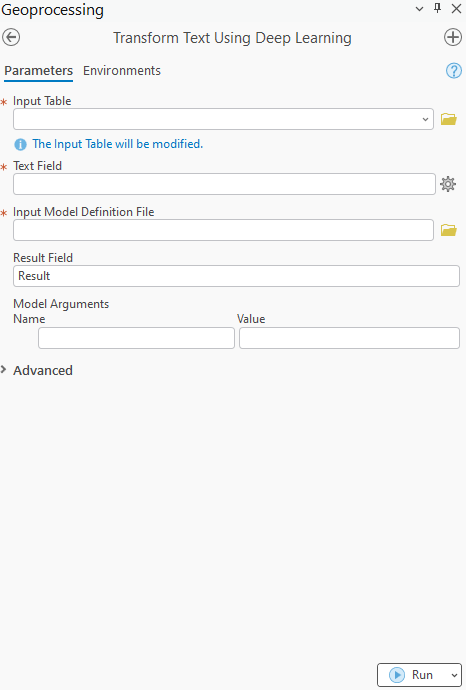

## Sample Input Table

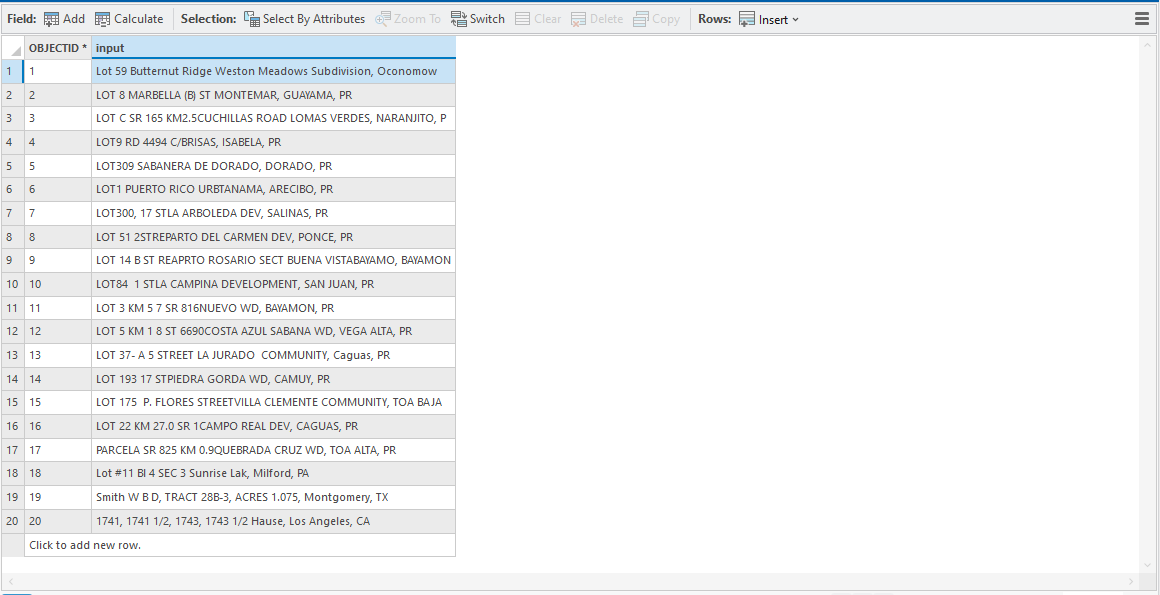

## After Extension file loading

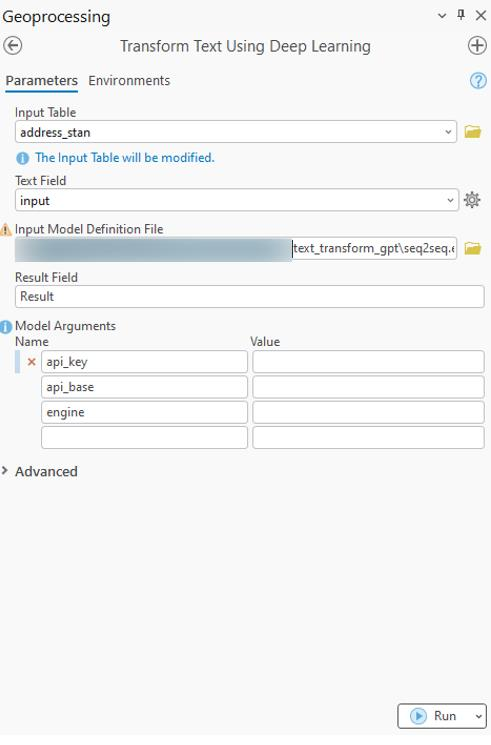

## Sample Output Table

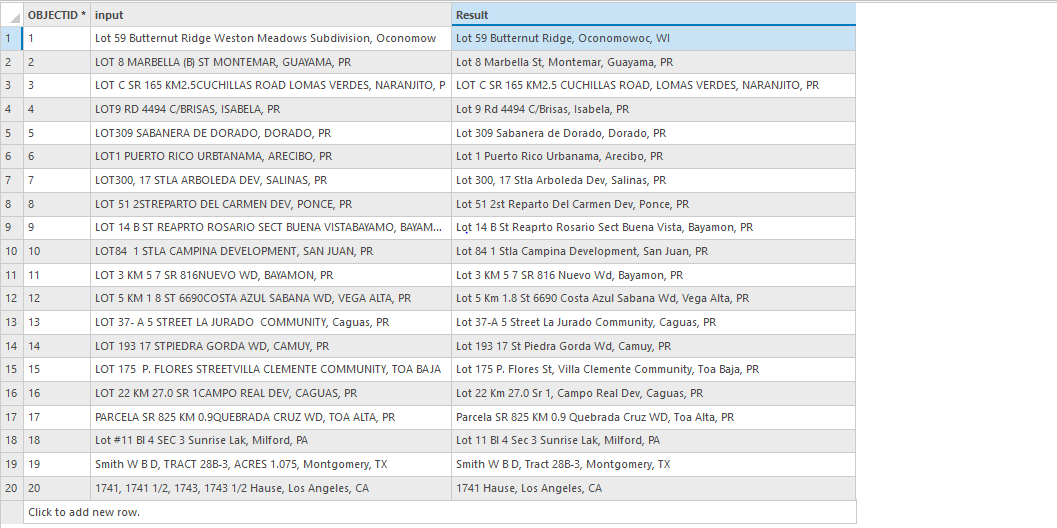

## Conclusion

In this notebook, we developed an address standardization model using GPT-3.5 with extensibility function. The dataset consisted of non-standard, incorrect house addresses from the United States. We leveraged the capabilities of GPT-3.5 to efficiently standardize input house addresses. Below are the results from the sample inputs.

In [ ]:
| Input                                                                   | Output                                                         |
| ----------------------------------------------------------------------- | -------------------------------------------------------------- |
| Lot 59 Butternut Ridge Weston Meadows Subdivision, Oconomowoc, WI       | Lot 59 Butternut Ridge, Oconomowoc, WI                         |
| LOT 8 MARBELLA (B) ST MONTEMAR, GUAYAMA, PR                             | Lot 8 Marbella St, Montemar, Guayama, PR                       |
| LOT C SR 165 KM2.5CUCHILLAS ROAD LOMAS VERDES, NARANJITO, PR            | LOT C SR 165 KM2.5 CUCHILLAS ROAD, LOMAS VERDES, NARANJITO, PR |
| LOT9 RD 4494 C/BRISAS, ISABELA, PR                                      | Lot 9 Rd 4494 C/Brisas, Isabela, PR                            |
| LOT309 SABANERA DE DORADO, DORADO, PR                                   | Lot 309 Sabanera de Dorado, Dorado, PR                         |
| LOT1 PUERTO RICO URBTANAMA, ARECIBO, PR                                 | Lot 1 Puerto Rico Urbanama, Arecibo, PR                        |
| LOT300, 17 STLA ARBOLEDA DEV, SALINAS, PR                               | Lot 300, 17 Stla Arboleda Dev, Salinas, PR                     |
| LOT 51 2STREPARTO DEL CARMEN DEV, PONCE, PR                             | Lot 51 2st Reparto Del Carmen Dev, Ponce, PR                   |
| LOT 14 B ST REAPRTO ROSARIO SECT BUENA VISTABAYAMO, BAYAMON, PR         | Lot 14 B St Reaprto Rosario Sect Buena Vista, Bayamon, PR      |
| LOT84  1 STLA CAMPINA DEVELOPMENT, SAN JUAN, PR                         | Lot 84 1 Stla Campina Development, San Juan, PR                |
| LOT 3 KM 5 7 SR 816NUEVO WD, BAYAMON, PR                                | Lot 3 KM 5 7 SR 816 Nuevo Wd, Bayamon, PR                      |
| LOT 5 KM 1 8 ST 6690COSTA AZUL SABANA WD, VEGA ALTA, PR                 | Lot 5 Km 1.8 St 6690 Costa Azul Sabana Wd, Vega Alta, PR       |
| LOT 37- A 5 STREET LA JURADO  COMMUNITY, Caguas, PR                     | Lot 37-A 5 Street La Jurado Community, Caguas, PR              |
| LOT 193 17 STPIEDRA GORDA WD, CAMUY, PR                                 | Lot 193 17 St Piedra Gorda Wd, Camuy, PR                       |
| LOT 175  P. FLORES STREETVILLA CLEMENTE COMMUNITY, TOA BAJA, PR         | Lot 175 P. Flores St, Villa Clemente Community, Toa Baja, PR   |
| LOT 22 KM 27.0 SR 1CAMPO REAL DEV, CAGUAS, PR                           | Lot 22 Km 27.0 Sr 1, Campo Real Dev, Caguas, PR                |
| PARCELA SR 825 KM 0.9QUEBRADA CRUZ WD, TOA ALTA, PR                     | Parcela SR 825 KM 0.9 Quebrada Cruz WD, Toa Alta, PR           |
| Lot #11 Bl 4 SEC 3 Sunrise Lak, Milford, PA                             | Lot 11 Bl 4 Sec 3 Sunrise Lak, Milford, PA                     |
| Smith W B D, TRACT 28B-3, ACRES 1.075, Montgomery, TX                   | Smith W B D, Tract 28B-3, Montgomery, TX                       |
| 1741, 1741 1/2, 1743, 1743 1/2 Hause, Los Angeles, CA                   | 1741 Hause, Los Angeles, CA                                    |